#Project 2

###Libraries


In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import requests
from sklearn.cluster import DBSCAN
import folium
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

###Load Data and Extract Visits

In [2]:
with open("location-history.json", "r") as f:
    data = json.load(f)

visits = []
for entry in data:
    if "visit" in entry:
        try:
            start = datetime.fromisoformat(entry["startTime"])
            end = datetime.fromisoformat(entry["endTime"])
            duration = (end - start).total_seconds() / 60

            place_str = entry["visit"]["topCandidate"]["placeLocation"]
            lat_str, lon_str = place_str.replace("geo:", "").split(",")
            latitude = float(lat_str)
            longitude = float(lon_str)

            visits.append({
                "startTime": start,
                "endTime": end,
                "duration_minutes": duration,
                "latitude": latitude,
                "longitude": longitude,
                "placeID": entry["visit"]["topCandidate"].get("placeID", None),
                "semanticType": entry["visit"]["topCandidate"].get("semanticType", None),
                "hierarchyLevel": entry["visit"].get("hierarchyLevel", None),
                "visit_probability": float(entry["visit"].get("probability", 0)),
                "candidate_probability": float(entry["visit"]["topCandidate"].get("probability", 0))
            })
        except Exception as e:
            print(f"Skipping entry: {e}")
            continue

df_visits = pd.DataFrame(visits)

###Filter Data

In [3]:
df_significant = df_visits[df_visits['duration_minutes'] > 5].reset_index(drop=True)

###Label Each Visit Using Google Places API

In [4]:
def get_place_info(lat, lon, api_key):
    try:
        url = f"https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={lat},{lon}&radius=50&key={api_key}"
        response = requests.get(url)
        data = response.json()

        if 'results' in data and data['results']:
            top_result = data['results'][0]
            name = top_result.get('name', 'Unknown')
            types = top_result.get('types', [])
            return name, types
        else:
            return 'Unknown', []
    except Exception as e:
        print(f"API error: {e}")
        return 'Unknown', []

api_key = ""
df_significant['place_name_initial'] = ''
df_significant['place_types_initial'] = ''

for i, row in df_significant.iterrows():
    name, types = get_place_info(row['latitude'], row['longitude'], api_key)
    df_significant.at[i, 'place_name_initial'] = name
    df_significant.at[i, 'place_types_initial'] = ', '.join(types)
    print(f"Labeled {i+1}/{len(df_significant)}: {name}")


Labeled 1/240: Jefferson Park Avenue
Labeled 2/240: 163-113 Maury Ave
Labeled 3/240: George Welsh Way
Labeled 4/240: 284-294 McCormick Rd
Labeled 5/240: Emmet Street South
Labeled 6/240: 163-113 Maury Ave
Labeled 7/240: George Welsh Way
Labeled 8/240: 163-113 Maury Ave
Labeled 9/240: 284-294 McCormick Rd
Labeled 10/240: Staunton
Labeled 11/240: 102-104 Flyfoot Dr
Labeled 12/240: Comfort Inn & Suites
Labeled 13/240: Unknown
Labeled 14/240: Snowden Bridge Residence Club
Labeled 15/240: Dollar Tree
Labeled 16/240: Snowden Bridge Residence Club
Labeled 17/240: Unknown
Labeled 18/240: Snowden Bridge Residence Club
Labeled 19/240: DaVita Rutherford Crossing Dialysis
Labeled 20/240: McDonald's
Labeled 21/240: Unknown
Labeled 22/240: 126-198 N Braddock St
Labeled 23/240: Unknown
Labeled 24/240: Unknown
Labeled 25/240: Snowden Bridge Residence Club
Labeled 26/240: Frontier Center Trail
Labeled 27/240: 199-157 Clarke Ct
Labeled 28/240: 284-294 McCormick Rd
Labeled 29/240: University of Virginia


###DBSCAN Clustering

In [5]:
coords = np.radians(df_significant[['latitude', 'longitude']])
kms_per_radian = 6371.0088
epsilon = 0.1 / kms_per_radian

db = DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric='haversine')
df_significant['location_cluster'] = db.fit_predict(coords)

###Compute Centroids and Label the Centroids with Google Places API

In [6]:
centroids = df_significant.groupby('location_cluster')[['latitude', 'longitude']].mean().reset_index()
cluster_labels = {}

for _, row in centroids.iterrows():
    cluster_id = row['location_cluster']
    if cluster_id == -1:
        cluster_labels[cluster_id] = ('Noise', '')
        continue
    name, types = get_place_info(row['latitude'], row['longitude'], api_key)
    cluster_labels[cluster_id] = (name, ', '.join(types))
    print(f"Cluster {cluster_id} labeled as {name}")

df_significant['final_place_name'] = df_significant['location_cluster'].map(lambda x: cluster_labels.get(x, ('Unknown', ''))[0])
df_significant['final_place_types'] = df_significant['location_cluster'].map(lambda x: cluster_labels.get(x, ('Unknown', ''))[1])

df_significant.to_csv("clustered_labeled_visits.csv", index=False)

Cluster 0.0 labeled as 163-113 Maury Ave
Cluster 1.0 labeled as George Welsh Way
Cluster 2.0 labeled as 284-294 McCormick Rd
Cluster 3.0 labeled as Emmet Street South
Cluster 4.0 labeled as Staunton
Cluster 5.0 labeled as 102-104 Flyfoot Dr
Cluster 6.0 labeled as Unknown
Cluster 7.0 labeled as Snowden Bridge Residence Club
Cluster 8.0 labeled as Unknown
Cluster 9.0 labeled as DaVita Rutherford Crossing Dialysis
Cluster 10.0 labeled as University of Virginia
Cluster 11.0 labeled as 485-457 Floyd Dr
Cluster 12.0 labeled as Charlottesville
Cluster 13.0 labeled as 2151-2111 Reservoir St
Cluster 14.0 labeled as CVS Pharmacy
Cluster 15.0 labeled as Dranesville
Cluster 16.0 labeled as Charlottesville
Cluster 17.0 labeled as 1254-1276 US-29 BUS
Cluster 18.0 labeled as 1924-1914 Arlington Blvd
Cluster 19.0 labeled as Alamo Drafthouse Cinema Winchester
Cluster 20.0 labeled as 557-563 Brandon Ave
Cluster 21.0 labeled as Bond Street
Cluster 22.0 labeled as Arlington
Cluster 23.0 labeled as Tysons


###Map Visualization

In [7]:
cluster_centroids = df_significant.groupby('location_cluster')[['latitude', 'longitude']].mean().reset_index()
map_center = [df_significant['latitude'].mean(), df_significant['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=14)

for _, row in cluster_centroids.iterrows():
    cluster_id = row['location_cluster']
    label = cluster_labels.get(cluster_id, ('Unknown', 'Unknown'))
    cluster_df = df_significant[df_significant['location_cluster'] == cluster_id]
    visits = len(cluster_df)

    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{label[0]} ({label[1]})<br>Visits: {visits}",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

m.save("significant_locations_map.html")

###Summary of the Clusters

In [8]:
cluster_summary = df_significant.groupby('location_cluster').agg({
    'final_place_name': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
    'final_place_types': lambda x: ', '.join(pd.Series(x).mode()) if not pd.Series(x).mode().empty else 'Unknown',
    'duration_minutes': ['mean', 'count'],
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

cluster_summary.columns = [
    'cluster_id',
    'location_name',
    'common_types',
    'avg_duration_minutes',
    'visit_count',
    'centroid_latitude',
    'centroid_longitude'
]

cluster_summary = cluster_summary.sort_values('visit_count', ascending=False)

print("\nTop Clusters by Visit Count:")
print(cluster_summary.head(10))


Top Clusters by Visit Count:
    cluster_id                  location_name  \
1            0              163-113 Maury Ave   
0           -1                          Noise   
3            2           284-294 McCormick Rd   
2            1               George Welsh Way   
9            8                        Unknown   
16          15                    Dranesville   
8            7  Snowden Bridge Residence Club   
6            5             102-104 Flyfoot Dr   
13          12                Charlottesville   
7            6                        Unknown   

                        common_types  avg_duration_minutes  visit_count  \
1                              route            525.973654           52   
0                                                61.115220           36   
3                              route            157.028465           26   
2                              route            145.119800           16   
9                                               414.988

###Defined Labels and Count each Accuracy Level

In [9]:
cluster_data = [
    # (cluster, assigned_label, place_type, true_label, accuracy)
    (0, "163-113 Maury Ave", "route", "My Apartment", "Partial"),
    (1, "George Welsh Way", "route", "Rice Hall", "Correct"),
    (2, "284-294 McCormick Rd", "route", "Library/Class Sidewalk", "Partial"),
    (3, "Emmet Street South", "route", "Central Grounds Parking Garage", "Correct"),
    (4, "Staunton", "locality, political", "Sheetz", "Correct"),
    (5, "102-104 Flyfoot Dr", "route", "Golden Path Academy (Across Mom's House)", "Incorrect"),
    (-1, "Noise", "()", "Random Area", "Incorrect"),
    (6, "Unknown", "Unknown", "Mom's House", "Correct"),
    (7, "Snowden Bridge Residence Club", "POI", "Clubhouse on Home Street", "Incorrect"),
    (8, "Unknown", "Unknown", "Boyfriend’s House", "Correct"),
    (9, "DaVita Rutherford Crossing Dialysis", "POI", "DaVita Rutherford Crossing Dialysis", "Incorrect"),
    (10, "University of Virginia", "locality", "Thornton Hall", "Correct"),
    (11, "485-457 Floyd Dr", "route", "Gooch/Dillard Area", "Partial"),
    (12, "Charlottesville", "locality", "USPS", "Correct"),
    (13, "2151-2111 Reservoir St", "route", "Boyfriend’s Apartment", "Correct"),
    (14, "CVS Pharmacy", "POI", "Target", "Correct"),
    (15, "Dranesville", "locality", "Pool Near Dad's House", "Partial"),
    (16, "Charlottesville", "locality", "International Residential College", "Correct"),
    (17, "1254-1276 US-29 BUS", "route", "Cook Out", "Correct"),
    (18, "1924-1914 Arlington Blvd", "route", "McDonald's", "Correct"),
    (19, "Alamo Drafthouse Cinema Winchester", "POI", "Alamo", "Correct"),
    (20, "557-563 Brandon Ave", "route", "Student Health Center", "Correct"),
    (21, "Bond Street", "route", "Charlottesville Shopping (road not building)", "Partial"),
    (22, "Arlington", "locality", "Pentagon City (not visited)", "Incorrect"),
    (23, "Tysons", "locality", "Tysons Corner Center", "Correct"),
    (24, "Fairfax", "locality", "Unknown Location", "Incorrect"),
    (25, "21738-21740 Towncenter Plz", "route", "Giant Grocery", "Correct"),
    (26, "Sterling", "locality", "Boba Tea Shopping Area", "Correct"),
    (27, "ALDI", "store", "ALDI", "Correct"),
    (28, "Winchester", "locality", "Boyfriend’s Haircut Place", "Correct"),
    (29, "South Pleasant Valley Road", "route", "Sheetz (not visited)", "Incorrect"),
]

df_accuracy = pd.DataFrame(cluster_data, columns=[
    "cluster", "assigned_label", "place_type", "true_label", "accuracy"
])

display(df_accuracy)

accuracy_counts = df_accuracy["accuracy"].value_counts()
accuracy_percent = df_accuracy["accuracy"].value_counts(normalize=True) * 100

print("\nAccuracy Counts:")
print(accuracy_counts)

print("\nAccuracy Percentages:")
print(accuracy_percent.round(2))

,cluster,assigned_label,place_type,true_label,accuracy
0,0,163-113 Maury Ave,route,My Apartment,Partial
1,1,George Welsh Way,route,Rice Hall,Correct
2,2,284-294 McCormick Rd,route,Library/Class Sidewalk,Partial
3,3,Emmet Street South,route,Central Grounds Parking Garage,Correct
4,4,Staunton,"locality, political",Sheetz,Correct
5,5,102-104 Flyfoot Dr,route,Golden Path Academy (Across Mom's House),Incorrect
6,-1,Noise,(),Random Area,Incorrect
7,6,Unknown,Unknown,Mom's House,Correct
8,7,Snowden Bridge Residence Club,POI,Clubhouse on Home Street,Incorrect
9,8,Unknown,Unknown,Boyfriend’s House,Correct



Accuracy Counts:
accuracy
Correct      19
Incorrect     7
Partial       5
Name: count, dtype: int64

Accuracy Percentages:
accuracy
Correct      61.29
Incorrect    22.58
Partial      16.13
Name: proportion, dtype: float64


###Accuracy Bar Chat

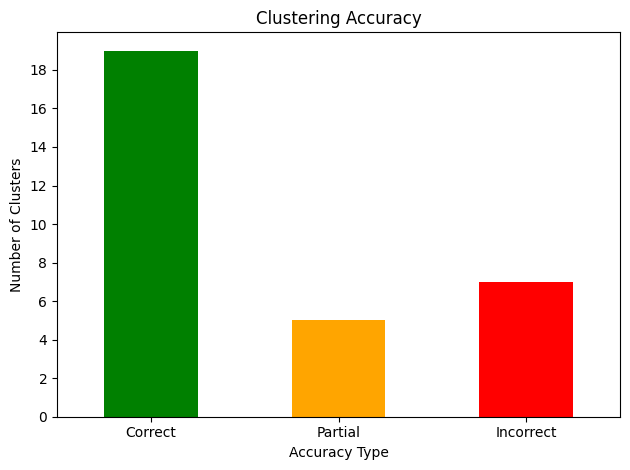

In [10]:
ordered_accuracy = ['Correct', 'Partial', 'Incorrect']
colors = ['green', 'orange', 'red']
accuracy_counts_ordered = accuracy_counts.reindex(ordered_accuracy)

ax = accuracy_counts_ordered.plot(kind='bar', color=colors)
ax.set_title("Clustering Accuracy")
ax.set_ylabel("Number of Clusters")
ax.set_xlabel("Accuracy Type")
ax.set_xticklabels(ordered_accuracy, rotation=0)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

###Accuracy Pie Chart

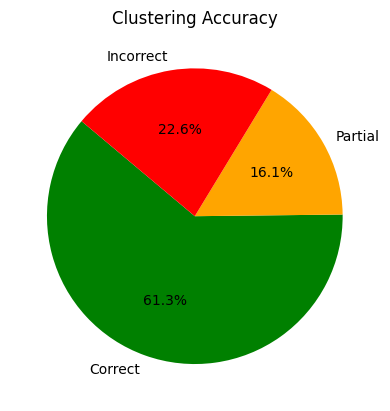

In [11]:
accuracy_counts_ordered.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Clustering Accuracy")
plt.ylabel("")
plt.show()


###Most Visited Locations Bar Chart

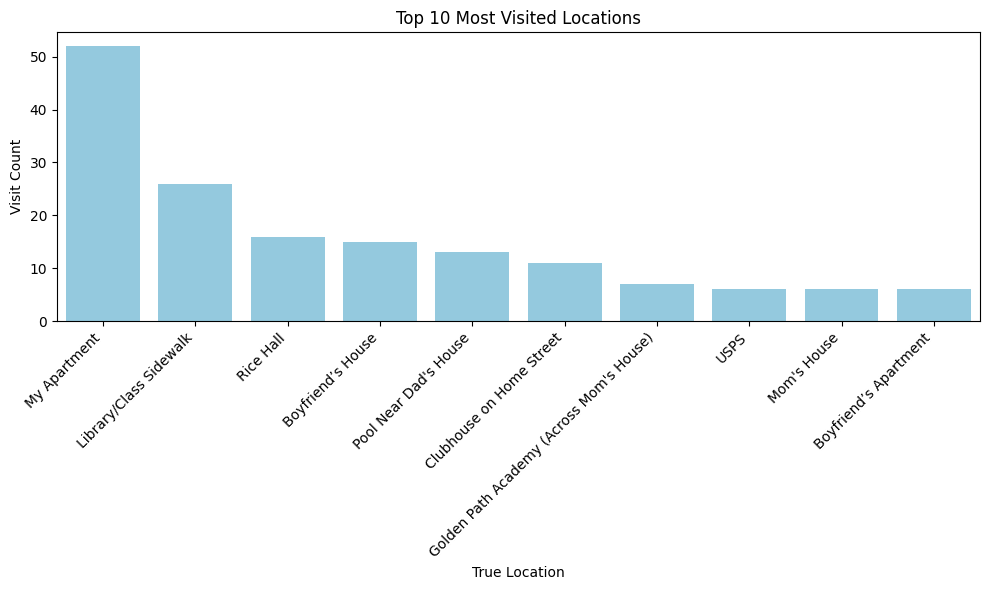

In [12]:
merged = pd.merge(df_accuracy, cluster_summary, left_on="cluster", right_on="cluster_id", how="left")

filtered = merged[merged["cluster"] != -1]

top_locations = filtered.sort_values("visit_count", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_locations, x="true_label", y="visit_count", color="skyblue")

plt.title("Top 10 Most Visited Locations")
plt.xlabel("True Location")
plt.ylabel("Visit Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()